In [46]:
## IMPORT LIBRARIES
import equiv_spectrum
import mpi_sf
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

def modify_rc():
    mpl.rcParams['figure.dpi'] = 250
    mpl.rc('text', usetex=True)
    mpl.rc('text.latex', preamble=r'''\usepackage{bm}
\usepackage{xcolor}''')
    #mpl.rcParams['text.latex.preamble']=[r"\usepackage{bm}", r"\usepackage{xcolor}"]
    mpl.rc('font', family='serif', serif='Computer Modern', size=8)

## NOTE: COMMENT THIS OUT IF YOU DON'T HAVE LATEX CONFIGURED FOR MATPLOTLIB
modify_rc()
modify_rc()

def pretty_axes(axx):
    axx.yaxis.set_ticks_position('both')
    axx.xaxis.set_ticks_position('both')
    axx.tick_params(axis='y', direction='in')
    axx.tick_params(axis='y', direction='in', which='minor')
    axx.tick_params(axis='x', direction='in')
    axx.tick_params(axis='x', direction='in', which='minor')
    axx.grid(linestyle=':', alpha=0.3, linewidth=0.5, color='gray')


Text(0.5, 1.0, '2D fBm field')

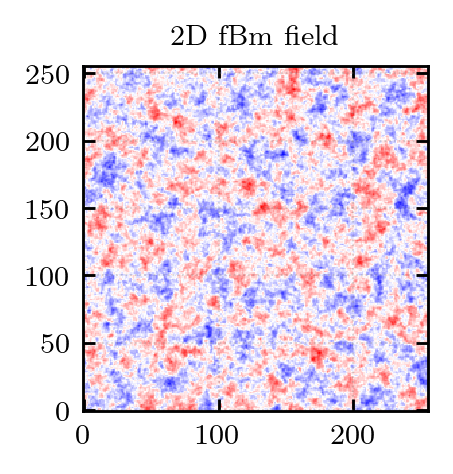

In [47]:
## Load data
f2 = np.load('example_data/example_fbm_2d.npy')
D = np.ndim(f2)
grid_dims = np.shape(f2)
N = np.min(grid_dims)
L = 2.*np.pi
phys_dims = [L for _ in range(D)]
dx = L/N
dk = 2.*np.pi/L
## Plot fbm field
fig, ax = plt.subplots(1, 1, figsize=(1.75, 1.75), dpi=256)
ax.imshow(f2, origin='lower', interpolation='none', cmap='bwr', vmin=-4., vmax=4.)
pretty_axes(ax)
ax.set_title('2D fBm field', fontsize=8.)

### __Step 1:__ Calculate the averaged second-order structure function $\bar{S}_{D}(\ell)$


/home/m/anaconda3/envs/EQUIV_SF/lib/python3.13/site-packages/scipy/stats/_binned_statistic.py:694: RuntimeWarning: Mean of empty slice
  stat = stat_func(np.array(bin_map[i]))


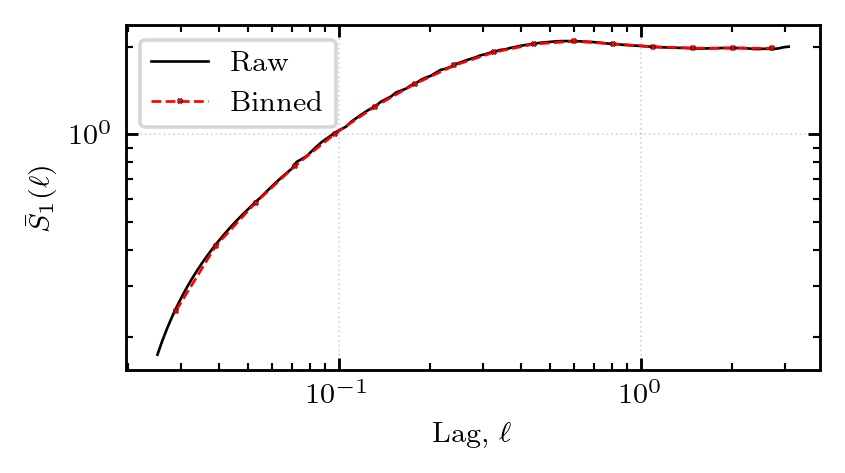

In [48]:
# Calculate the 2D second order structure function
vell, sf2 = mpi_sf.mpi_sf(f2)
ell = np.linalg.norm(vell, axis=1)*dx
ell = ell.reshape((N//2, N//2))
sf2 = sf2.reshape((N//2, N//2))
# Angle-average
ell, sf2, _ = equiv_spectrum.bin_data(ell, sf2, bin_func=np.nanmean, cut_excess=True, nan_small=False, min_bin=dx, max_bin=L/2., num_bins=N//2, bin_loc='center', log_space=True)
ell2 = ell[np.isfinite(sf2)]
sf22 = sf2[np.isfinite(sf2)]
sf2 = equiv_spectrum.logx_interpolate(ell2, sf22, ell)
# Bin and interpolate the angle averaged second order structure function
ell_b, sf2_b, _ = equiv_spectrum.bin_data(ell, sf2, bin_func=np.nanmean, cut_excess=True, nan_small=False, min_bin=dx, max_bin=L/2., num_bins=16, bin_loc='true_center', log_space=True)
ell_b2 = ell_b[np.isfinite(sf2_b)]
sf2_b2 = sf2_b[np.isfinite(sf2_b)]
sf2_b = equiv_spectrum.log_log_interpolate(ell_b2, sf2_b2, ell_b)
## Plot SF
fig, ax = plt.subplots(1, 1, figsize=(3.5, 1.75), dpi=256)
ax.loglog(ell, sf2, linestyle='-', color='black', linewidth=0.75, label='Raw')
ax.loglog(ell_b, sf2_b, color='red', linestyle='--', linewidth=0.75, marker='X', markeredgecolor='black', markersize=1.5, markeredgewidth=0.1, label='Binned')
pretty_axes(ax)
ax.set_xlabel(r'Lag, $\ell$')
ax.set_ylabel(r'$\bar{S}_{1}(\ell)$')
ax.legend()

### __Step 2:__ Create the "''"Uncorrected"''" estimate $\equiv \mathcal{B}^{-1} \mathcal{E}_{D}^{S}(k_{\mathrm{e}})$ with an appropriate $b$.
### __Step 3:__ Estimate the local power law slope of the "Uncorrected" estimate.
### __Step 4:__ Finally, take the "Uncorrected" spectrum and estimate the "Debiased" form of the equivalent spectrum.

<>:10: SyntaxWarning: invalid escape sequence '\m'
<>:11: SyntaxWarning: invalid escape sequence '\m'
<>:14: SyntaxWarning: invalid escape sequence '\m'
<>:15: SyntaxWarning: invalid escape sequence '\m'
<>:10: SyntaxWarning: invalid escape sequence '\m'
<>:11: SyntaxWarning: invalid escape sequence '\m'
<>:14: SyntaxWarning: invalid escape sequence '\m'
<>:15: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_73973/3550833303.py:10: SyntaxWarning: invalid escape sequence '\m'
  ax[0].loglog(ke, BfekS, linestyle='-.', color='red', linewidth=1.5, label='Uncorrected, $\mathcal{B}^{-1}\mathcal{E}_{1}^{S}(k_{\mathrm{e}})$')
/tmp/ipykernel_73973/3550833303.py:11: SyntaxWarning: invalid escape sequence '\m'
  ax[0].loglog(ke, fekS, linestyle='--', color='black', linewidth=1.5, label='Debiased, $\mathcal{E}_{1}^{S}(k_{\mathrm{e}})$')
/tmp/ipykernel_73973/3550833303.py:14: SyntaxWarning: invalid escape sequence '\m'
  ax[1].loglog(ko, BfekS/feko, linestyle='-.', color='red', linewidth

(0.5, 2.0)

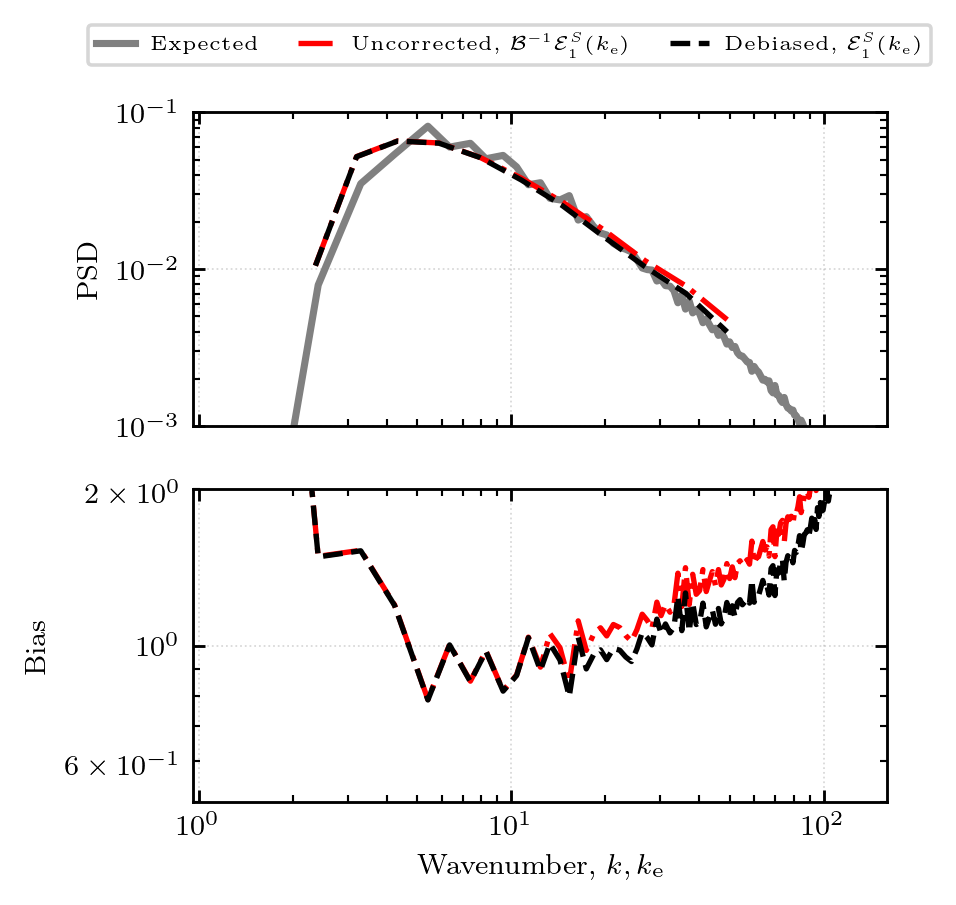

In [49]:
## Compare to FFT spectrum
kvec, fek = equiv_spectrum.per_spectrum(f2, phys_dims)
fek = fek*(dk/(2.*np.pi))**D
ko, feko = equiv_spectrum.integrate_spectrum(kvec, fek, phys_dims)
## Calculate the Uncorrected estimate, and the Debiased estimate
ke, BfekS, fekS = equiv_spectrum.equiv_spectrum(ell_b, sf2_b, D, np.sqrt(2.))
## Plot equivalent spectrum
fig, ax = plt.subplots(2, 1, figsize=(3.5, 3.5), dpi=256)
ax[0].loglog(ko, feko, linestyle='-', color='gray', linewidth=2., label='Expected')
ax[0].loglog(ke, BfekS, linestyle='-.', color='red', linewidth=1.5, label='Uncorrected, $\mathcal{B}^{-1}\mathcal{E}_{1}^{S}(k_{\mathrm{e}})$')
ax[0].loglog(ke, fekS, linestyle='--', color='black', linewidth=1.5, label='Debiased, $\mathcal{E}_{1}^{S}(k_{\mathrm{e}})$')
## Calculate the Uncorrected estimate, and the Debiased estimate (binned to ko)
ke, BfekS, fekS = equiv_spectrum.equiv_spectrum(ell_b, sf2_b, D, np.sqrt(2.), ko)
ax[1].loglog(ko, BfekS/feko, linestyle='-.', color='red', linewidth=1.5, label='Uncorrected, $\mathcal{B}^{-1}\mathcal{E}_{1}^{S}(k_{\mathrm{e}})$')
ax[1].loglog(ko, fekS/feko, linestyle='--', color='black', linewidth=1.5, label='Debiased, $\mathcal{E}_{1}^{S}(k_{\mathrm{e}})$')
pretty_axes(ax[0])
pretty_axes(ax[1])
ax[0].set_xticklabels([])
ax[1].set_xlabel(r'Wavenumber, $k,k_{\mathrm{e}}$')
ax[0].set_ylabel(r'PSD')
ax[1].set_ylabel(r'Bias')
ax[0].legend(loc=(-0.15, 1.15), ncols=3, fontsize=5.5)
ax[0].set_ylim((1e-3, 1e-1))
ax[1].set_ylim((5e-1, 2e0))